In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

In [2]:
import sys
sys.path.append('..')

from VAE.rg_dataset import LRG
from VAE.vae_models import VAE

In [3]:
lrg_data_set   = LRG(use_kittler=True, n_aug=10, blur=True, 
                       catalog_dir='../data/catalog/mrt-table3.txt', file_dir='../data/lrg')

data_loader_lrg   = data.DataLoader(lrg_data_set, batch_size=64, shuffle=False)

sample = iter(data_loader_lrg).next()
print(len(data_loader_lrg))

../data/lrg:	1442/1442
224


In [4]:
device = 'cpu'
# fixed values #
epochs, gam, cap = 100, 8, 20
###############
# b_vae_norot_unlrg_g10_ld2_epochs50_cap10
name_template = '../trained_models/b_vae_norot_unlrg_g{}_ld{}_epochs{}_cap{}'

In [5]:
lt_dim = 7
###############
# model_name = name_template.format(gam, lt_dim, epochs, cap)
model_name = '../trained_models/bvae_full_cap_0_g_1_ld7_epochs50'
vae = torch.load(model_name, map_location = device)
vae = vae.eval()
vae

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(2

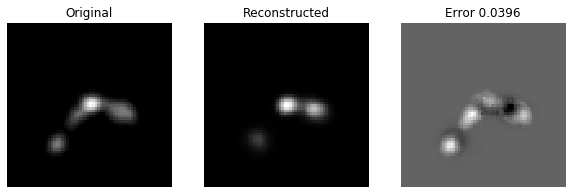

In [6]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
    
bce = F.binary_cross_entropy(torch.FloatTensor(s[0][0]), d.cpu())

f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0], cmap='gray')
ax[1].imshow(d.cpu()[0][0], cmap='gray')
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title('Original')
ax[1].set_title('Reconstructed')
ax[2].set_title('Error {:.4f}'.format(bce))
plt.show()

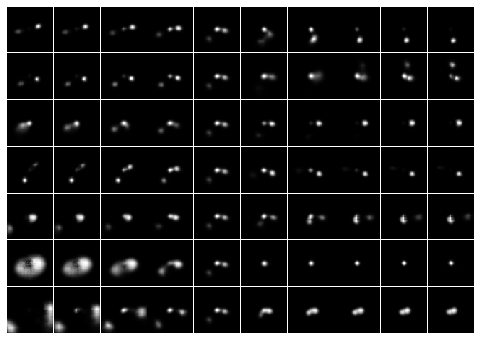

tensor([ 0.1527, -1.9327,  1.6736, -0.0590, -0.4943, -1.1766,  4.2335])


In [7]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]

r = 10
nimg = r * lt_dim
k = 1
m = 1
fig = plt.figure(figsize=(58.5/lt_dim, 6))

# fig.suptitle('Lenght six feature vector', fontsize=28)
gs1 = gridspec.GridSpec(lt_dim, r, figure=fig)
gs1.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

for i in range(lt_dim):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = vae.encode(s.to(device))[0][0]
            v = e[i]
            nv = -4*k + v + k*j
            e[i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')

plt.savefig('foo.png', dpi=300)
plt.show()
print(e)

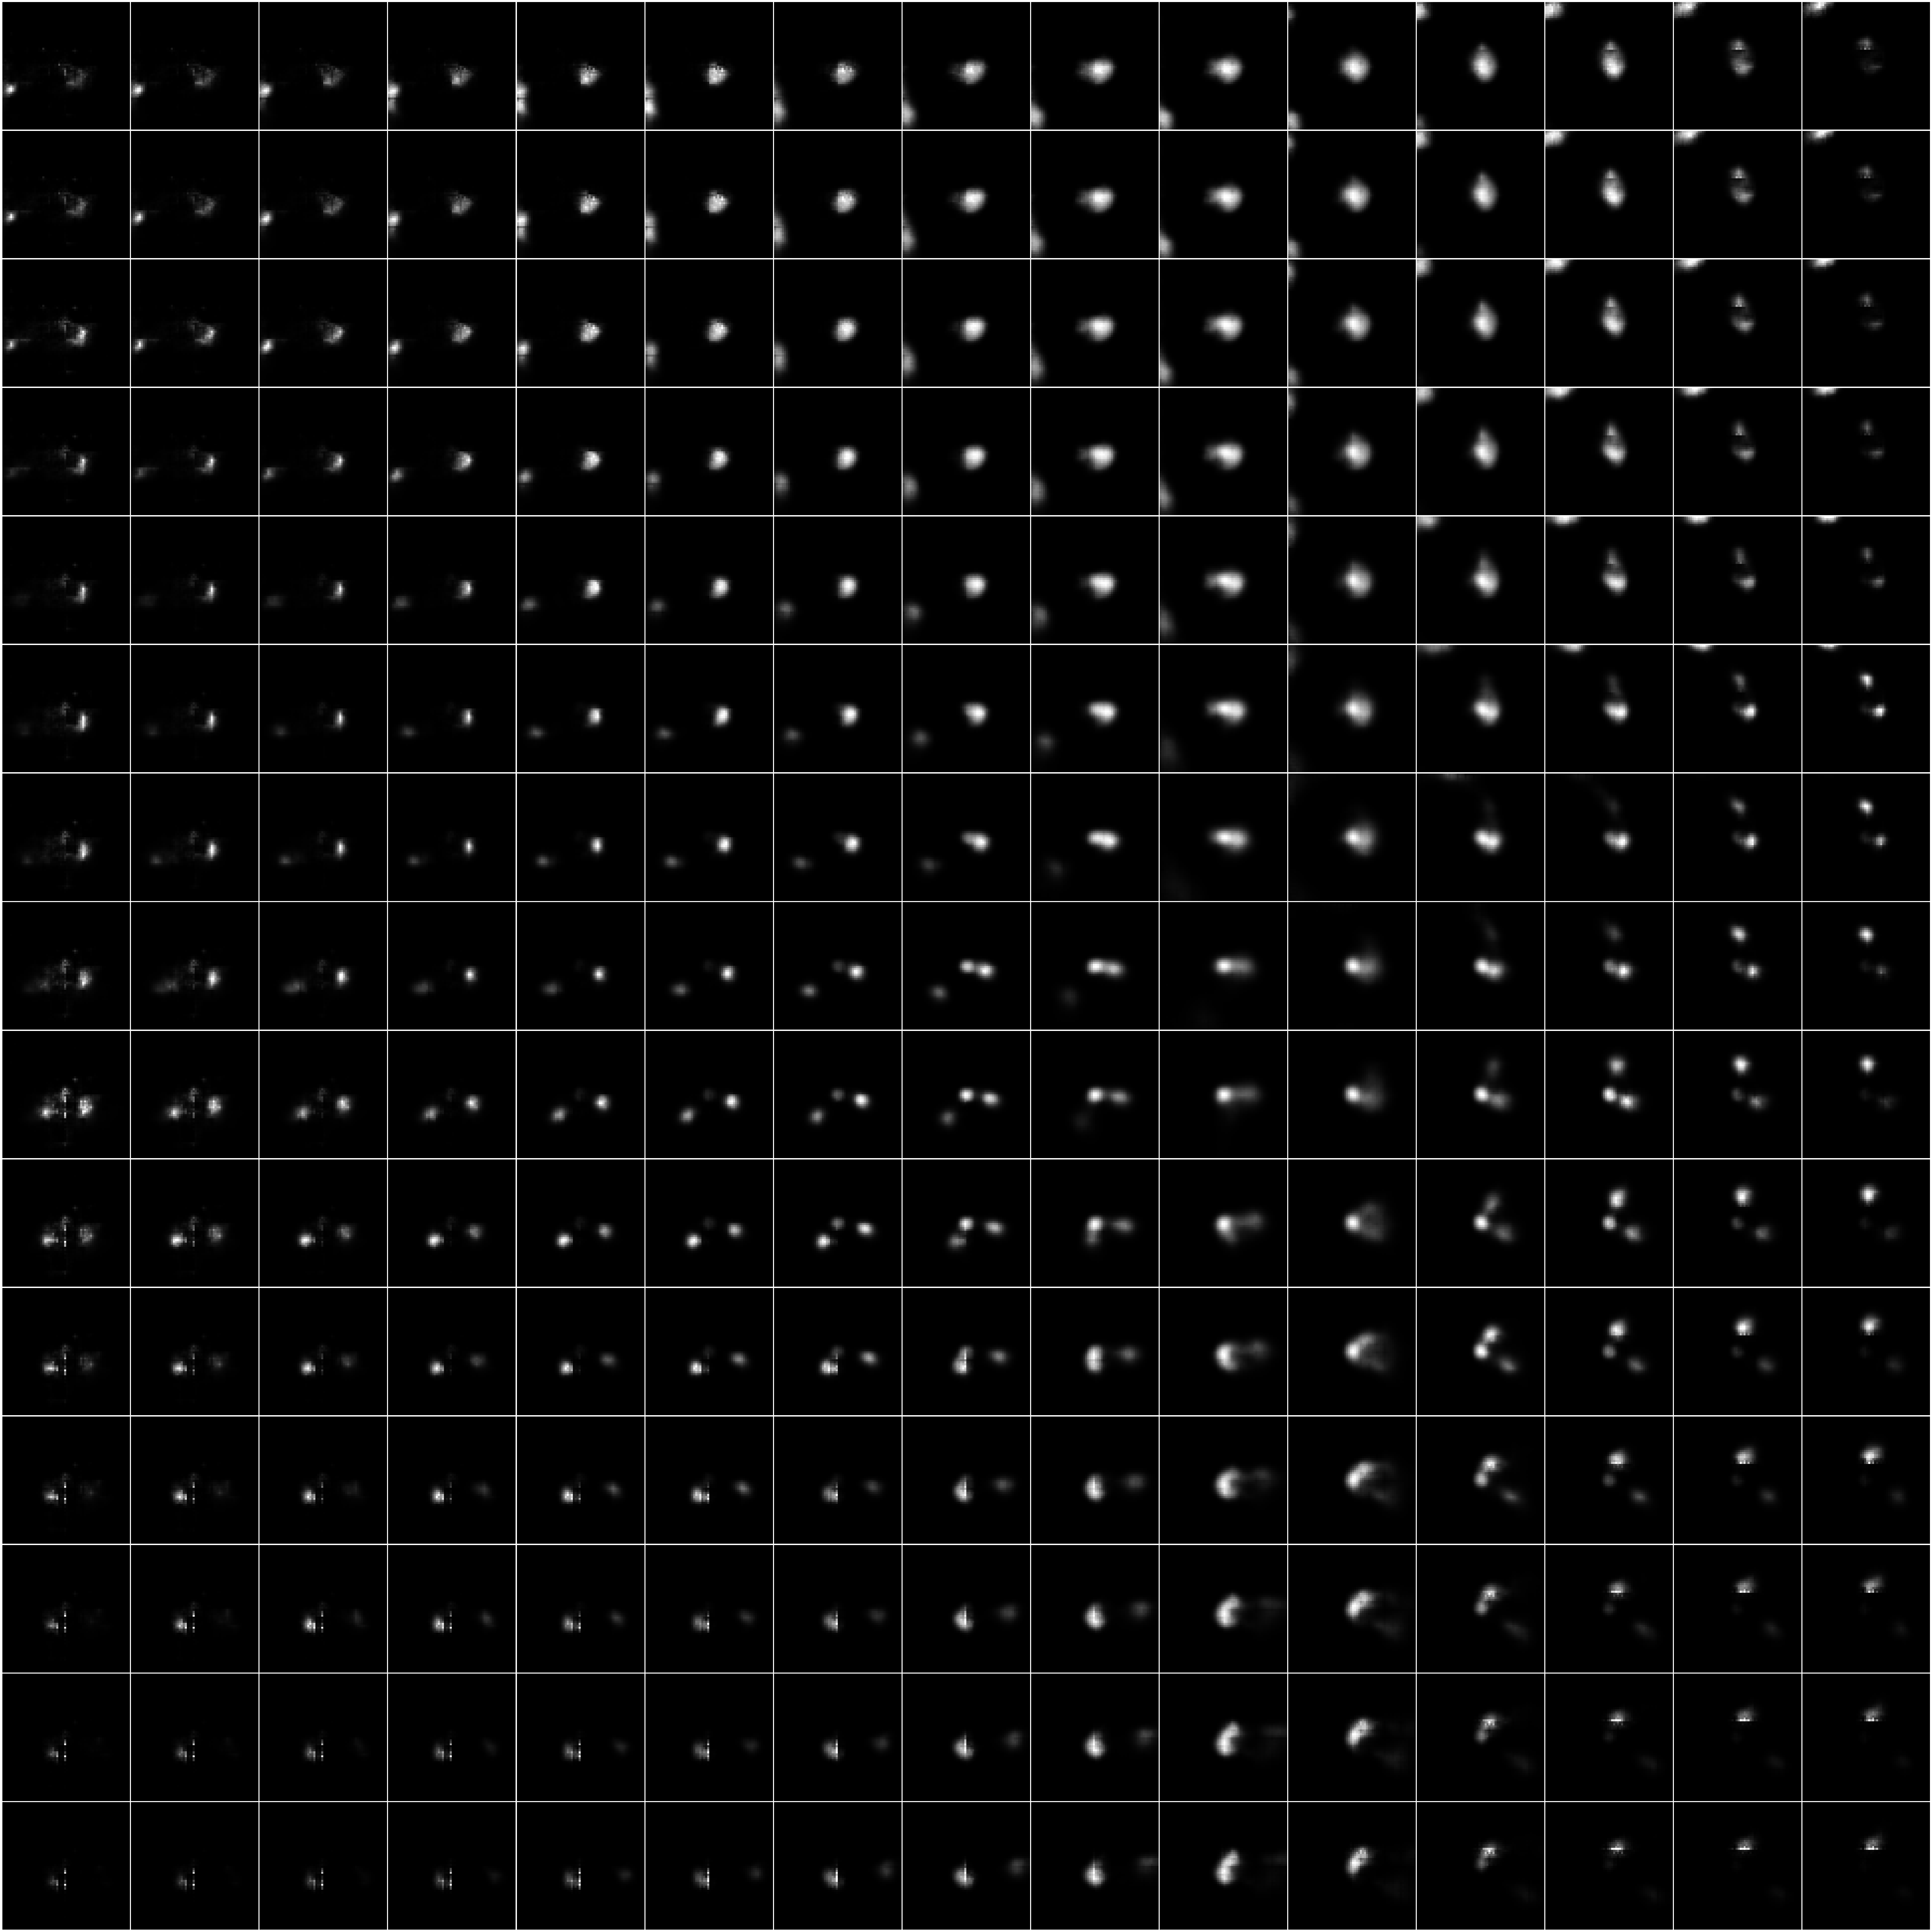

In [8]:
r = 15
nimg = r * 15
k = 1
l = k
plt.figure(figsize=(101.3, 104))
gs1 = gridspec.GridSpec(15, r)
gs1.update(wspace=0.01, hspace=0.01)

for i in range(15):
    for j in range(r):
        ax1 = plt.subplot(gs1[i*r+j])
        plt.axis('off')
        with torch.no_grad():
            e = vae.encode(s.to(device))[0][0]
            e[1] += k*(-r/2 + j)
            e[4] += l*(-r/2 + i)
            d = vae.decode(e).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')

In [12]:
train_losses = []
for i in range(4, 12):
    train_file = "../model_loss_data/train_loss_bvae_full_cap_10_g_8_lt_{}.npy".format(i)
    losses = np.load(train_file,allow_pickle=True)
    train_losses.append([l.item() for l in losses])
train_losses = np.array(train_losses)

In [13]:
train_losses.shape

(8, 30)

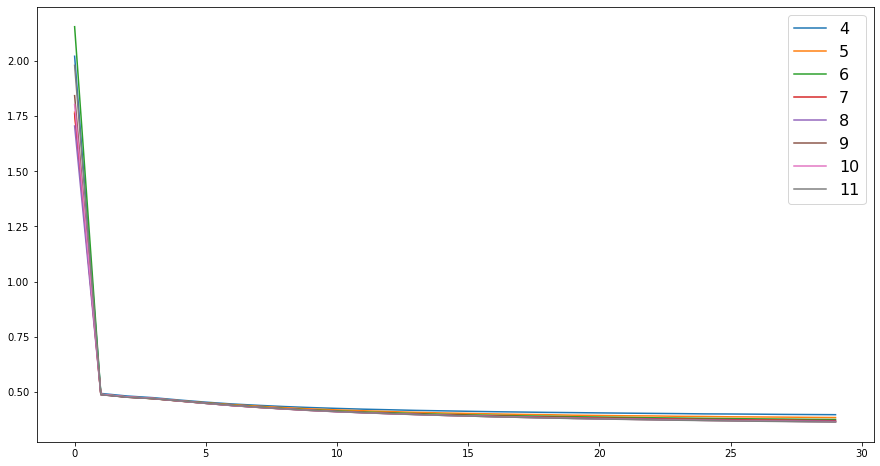

In [14]:
plt.figure(figsize=(15,8))
for i in range(4, 12):
    plt.plot(train_losses[i-4], label='{}'.format(i))
plt.legend(loc='upper right', prop={'size': 16})
plt.show()

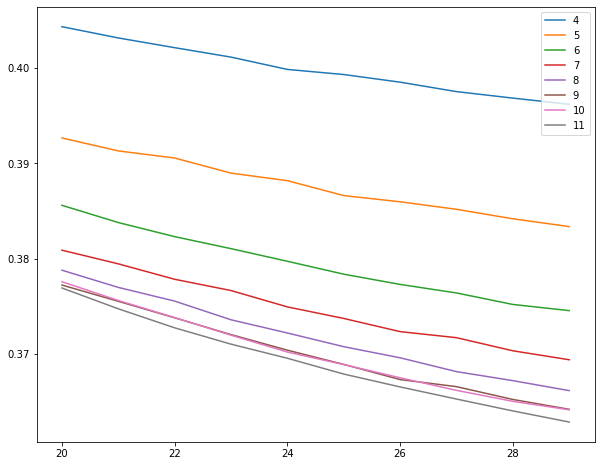

In [17]:
plt.figure(figsize=(10,8))

plt.clf()
for i in range(4, 12):
    plt.plot(np.arange(20, 30), train_losses[i-4][20:], label='{}'.format(i))
plt.legend(loc='upper right')
plt.show()

In [21]:
test_losses = []
for i in range(4, 12):
    train_file = "../model_loss_data/test_loss_bvae_full_cap_10_g_8_lt_{}.npy".format(i)
    losses = np.load(train_file,allow_pickle=True)
    test_losses.append([l.item() for l in losses])
test_losses = np.array(test_losses)

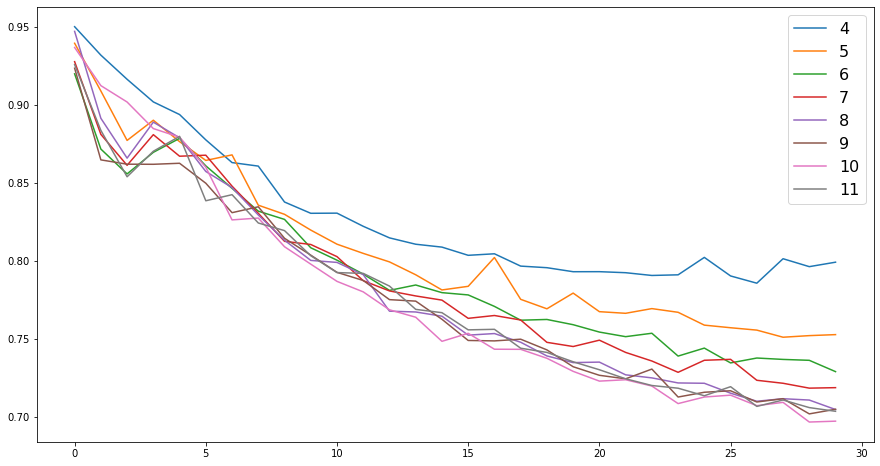

In [25]:
plt.figure(figsize=(15,8))
for i in range(4, 12):
    plt.plot(test_losses[i-4], label='{}'.format(i))
plt.legend(loc='upper right', prop={'size': 16})
plt.show()

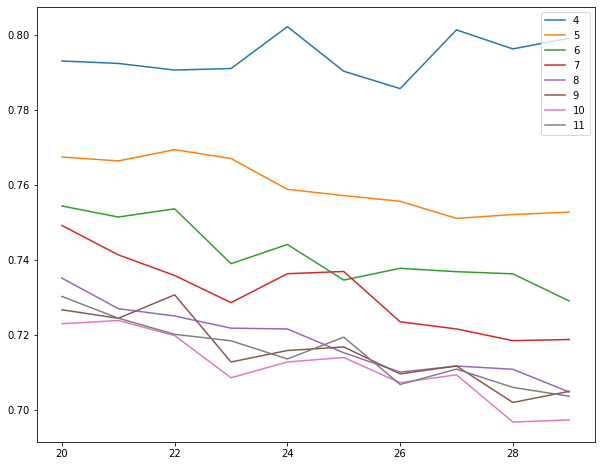

In [24]:
plt.figure(figsize=(10,8))

plt.clf()
for i in range(4, 12):
    plt.plot(np.arange(20, 30), test_losses[i-4][20:], label='{}'.format(i))
plt.legend(loc='upper right')
plt.show()